In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers accelerate bitsandbytes


!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install -q --upgrade transformers datasets accelerate evaluate scikit-learn pandas openpyxl geopy sentence-transformers peft ftfy seaborn matplotlib bitsandbytes country_converter pycountry optuna



In [ ]:
!pip install -q optuna

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import time
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from sentence_transformers import SentenceTransformer, util
import ftfy
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import difflib
import optuna
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch import nn


In [ ]:
df = pd.read_excel('final_dataset.xlsx')

In [ ]:
df.head()

,Article,Category,Location
0,Fatal daytime stabbing shocks Bamenda market d...,Crime,"Bamenda, Northwest Region, Cameroon"
1,Rio police seize 800kg of cocaine after shooto...,Crime,"Nova Iguaçu, Rio de Janeiro, Brazil"
2,Extortion‑linked arson wave guts San Pedro Sul...,Crime,"San Pedro Sula, Cortés Department, Honduras"
3,Chinese engineers abducted from Darfur road pr...,Kidnapping,"Nyala, South Darfur, Sudan"
4,Tour bus hijacked outside Acapulco; 18 holiday...,Kidnapping,"Acapulco, Guerrero, Mexico"


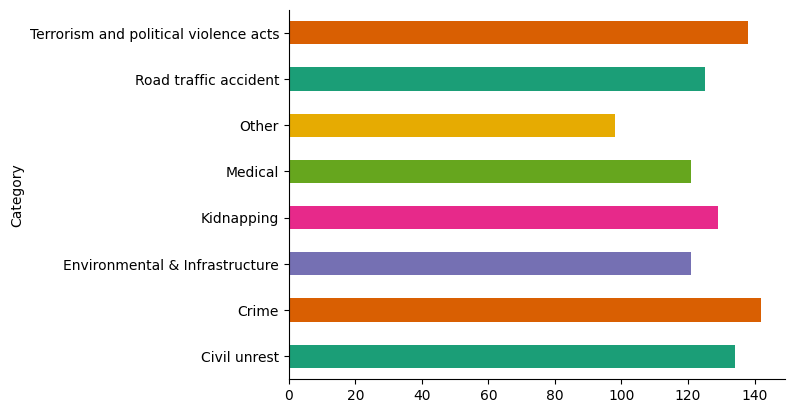

In [ ]:


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

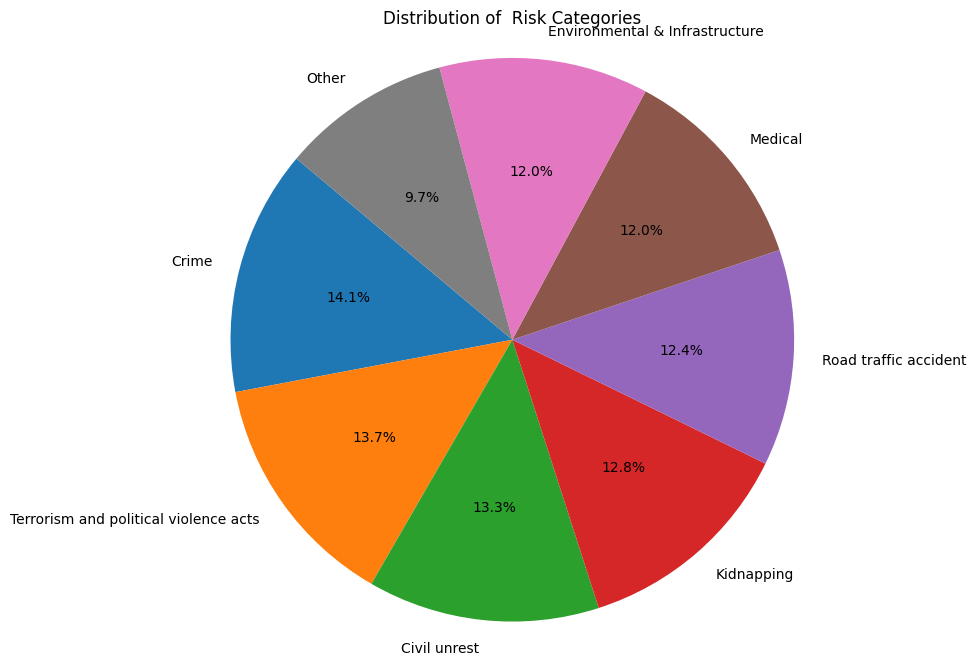

In [ ]:
category_counts = df['Category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)


plt.title('Distribution of  Risk Categories')

plt.axis('equal')

plt.show()

/tmp/ipython-input-10-231498605.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


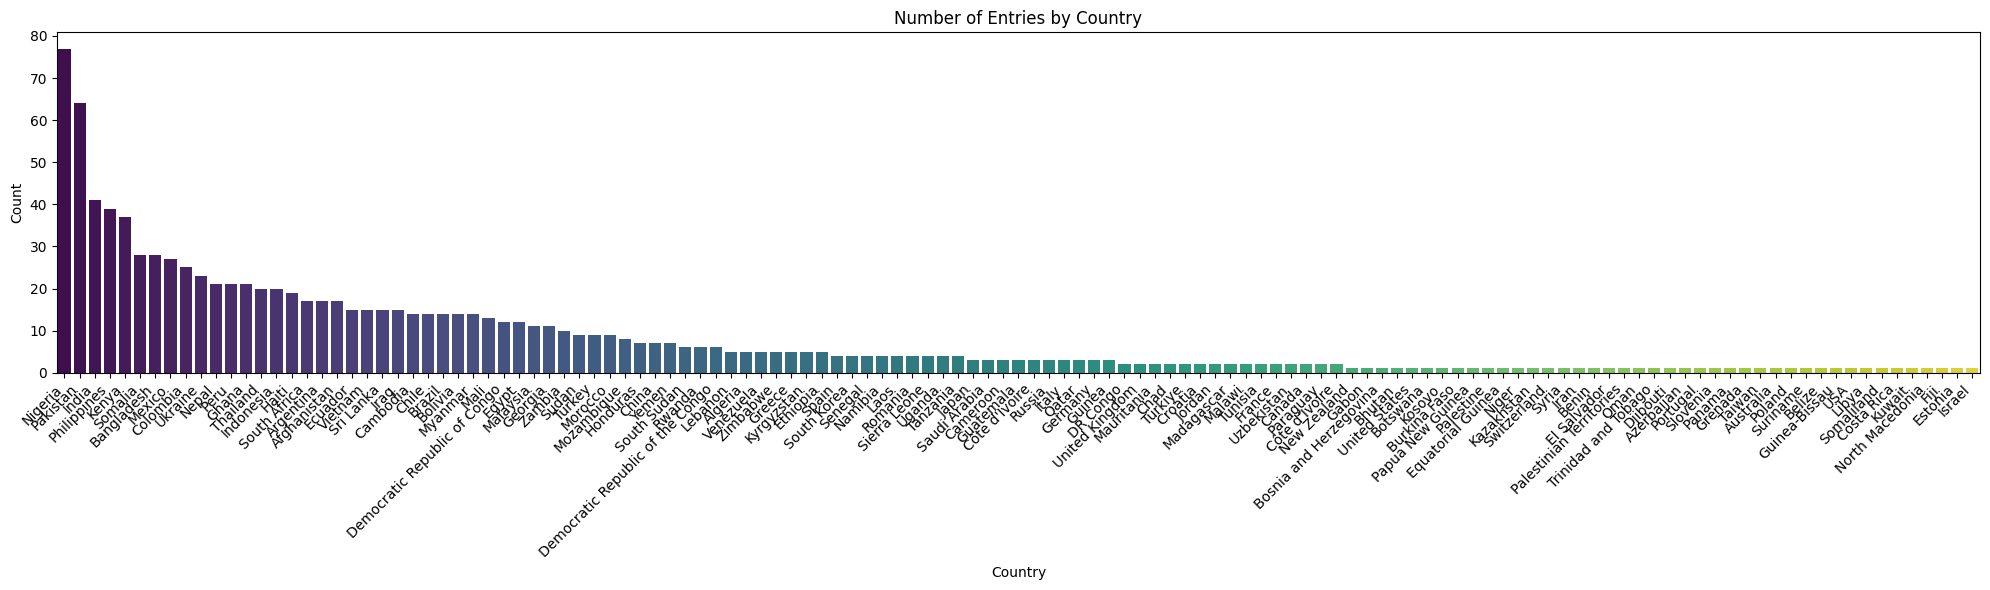

In [ ]:
df['Country'] = df['Location'].str.split(',').str[-1].str.strip()

country_counts = df['Country'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')

plt.title('Number of Entries by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
pip install country_converter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.8 MB/s eta 0:00:00


/tmp/ipython-input-18-1569653511.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=continent_counts.index, y=continent_counts.values, palette='hls')


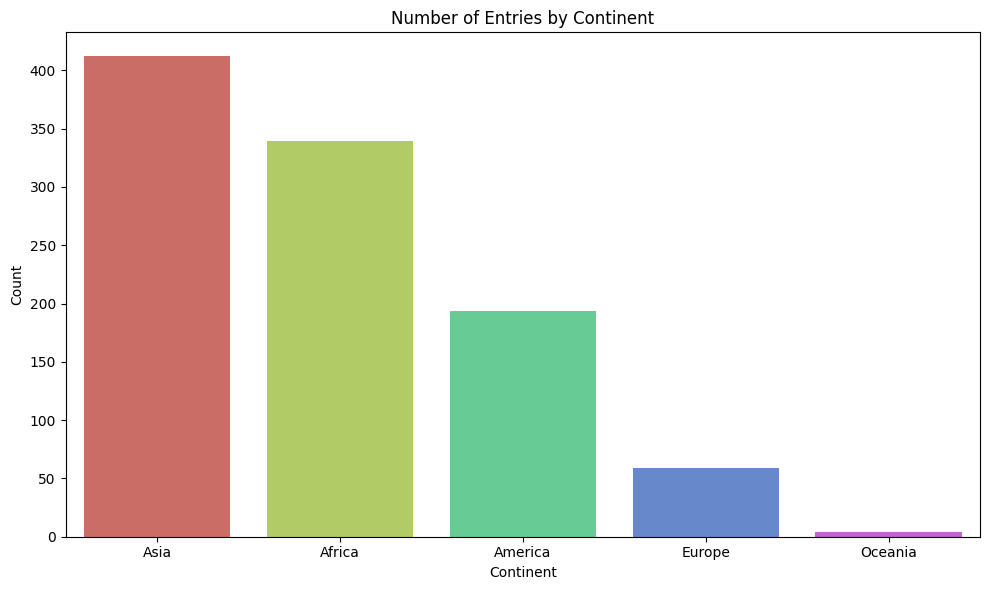

In [ ]:
import country_converter as coco
df['Continent'] = coco.convert(names=df['Country'], to='continent')

continent_counts = df['Continent'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values, palette='hls')

plt.title('Number of Entries by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

/tmp/ipython-input-22-1474356013.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='husl')


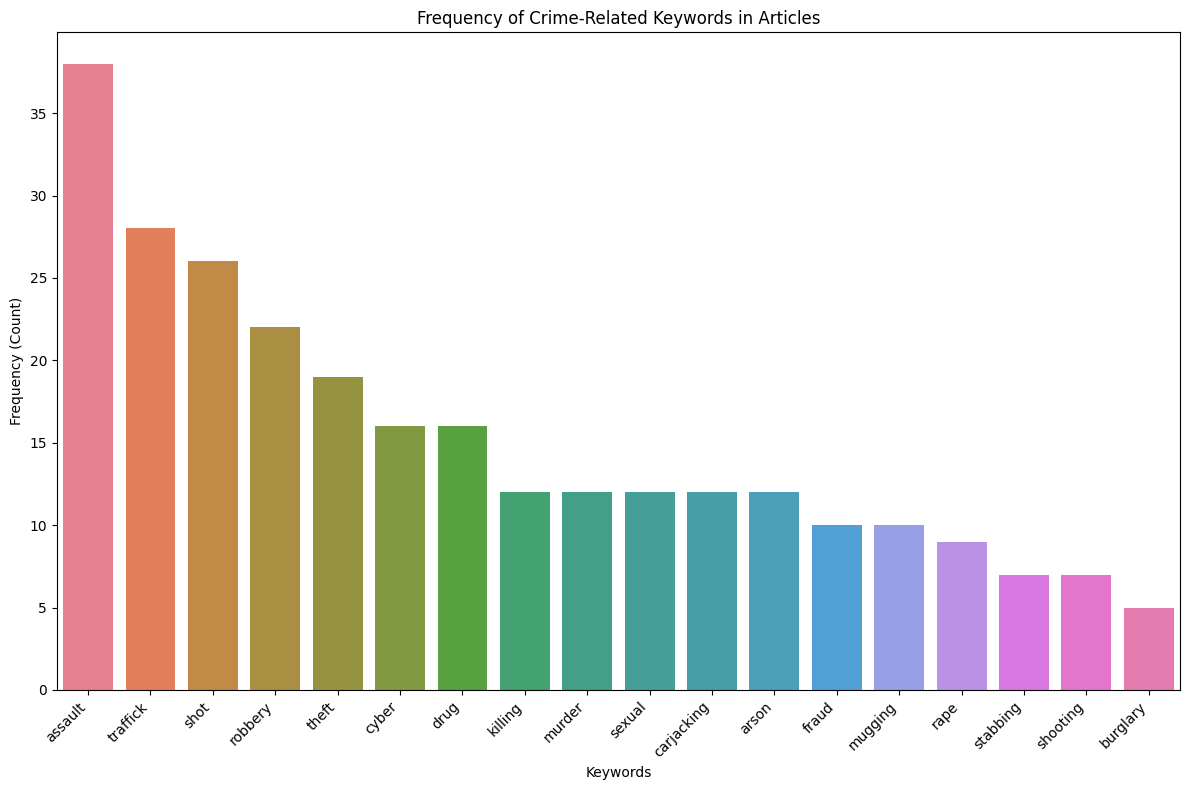

In [ ]:
crime_df = df[df['Category']=='Crime']
keyword_counts = {}
keywords = ['killing', 'murder', 'shot', 'shooting', 'stabbing', 'rape', 'sexual', 'mugging','theft', 'robbery', 'drug', 'traffick', 'fraud', 'arson', 'assault', 'cyber', 'burglary', 'carjacking']
for kw in keywords:
    keyword_counts[kw] = crime_df['Article'].str.lower().str.contains(kw).sum()
keyword_counts

keyword_series = pd.Series(keyword_counts)


sorted_keywords = keyword_series.sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='husl')


plt.title('Frequency of Crime-Related Keywords in Articles')
plt.xlabel('Keywords')
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


/tmp/ipython-input-27-693802347.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='Paired')


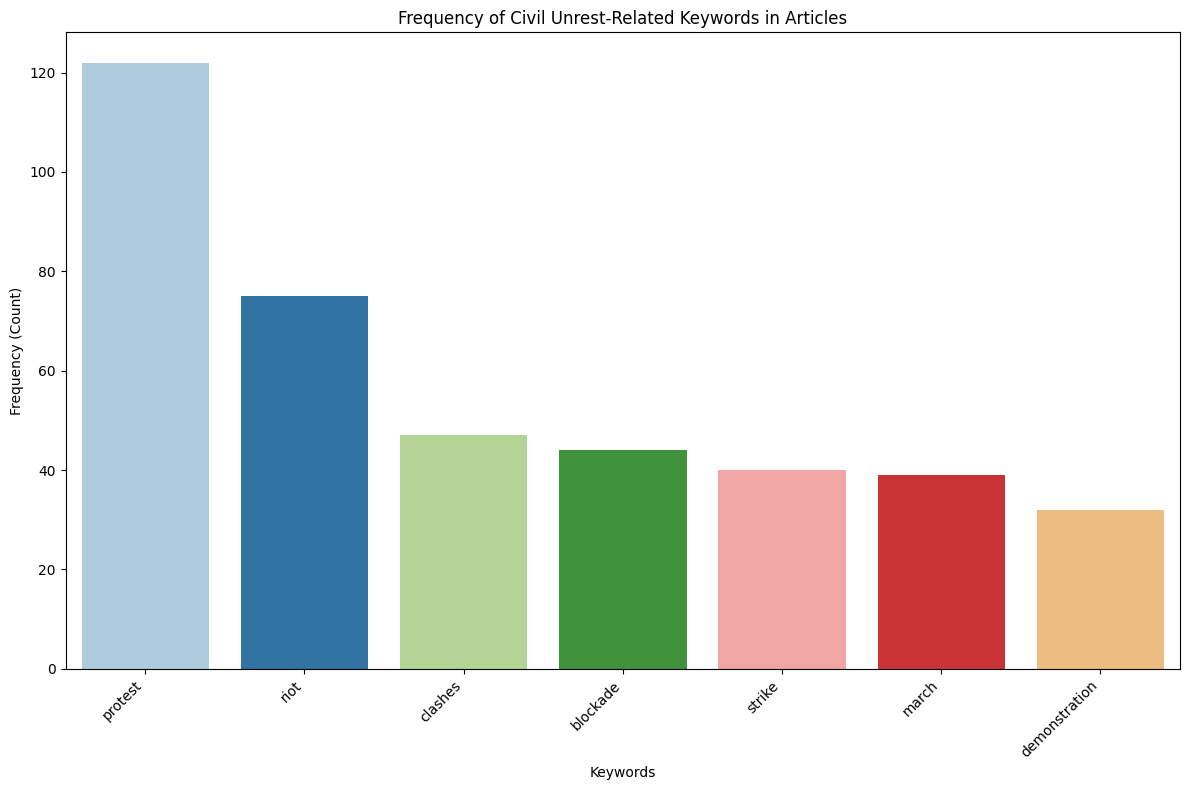

In [ ]:
civil_unrest_df = df[df['Category']=='Civil unrest']
keyword_counts = {}
keywords = ['protest','demonstration', 'riot', 'strike','march','clashes','blockade']
for kw in keywords:
    keyword_counts[kw] = civil_unrest_df['Article'].str.lower().str.contains(kw).sum()
keyword_counts

keyword_series = pd.Series(keyword_counts)

sorted_keywords = keyword_series.sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='Paired')

plt.title('Frequency of Civil Unrest-Related Keywords in Articles')
plt.xlabel('Keywords')
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


/tmp/ipython-input-31-3554210383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='Set2')


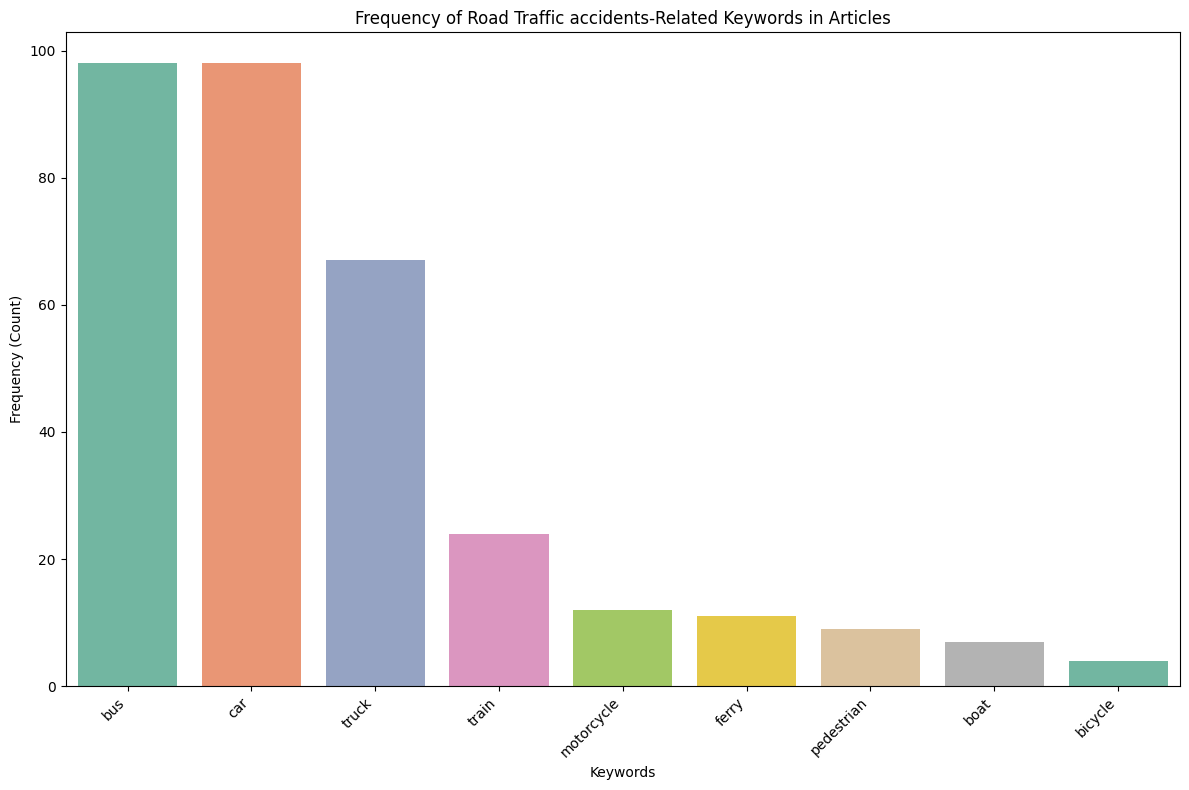

In [ ]:
rta_df = df[df['Category']=='Road traffic accident']
kw_rta = ['bus', 'train', 'car', 'truck', 'ferry', 'boat','bicycle', 'motorcycle', 'pedestrian']
rta_counts = {kw: rta_df['Article'].str.lower().str.contains(kw).sum() for kw in kw_rta}

keyword_series = pd.Series(rta_counts)


sorted_keywords = keyword_series.sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_keywords.index, y=sorted_keywords.values, palette='Set2')


plt.title('Frequency of Road Traffic accidents-Related Keywords in Articles')
plt.xlabel('Keywords')
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()



# hugging face installation

In [ ]:
!pip install transformers -q

In [ ]:
!pip install --upgrade -q datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 831.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does n

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [ ]:
model_name = "distilbert-base-uncased"

number_of_categories = 8


tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=number_of_categories)

print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
categories = df['Category'].unique()
len(categories)

8

In [ ]:
id2label = {idx: category for idx, category in enumerate(categories)}
label2id = {category: idx for idx, category in enumerate(categories)}

In [ ]:
df['labels'] = df['Category'].map(label2id)

In [ ]:
df.head()

,Article,Category,Location,labels
0,Fatal daytime stabbing shocks Bamenda market d...,Crime,"Bamenda, Northwest Region, Cameroon",0
1,Rio police seize 800kg of cocaine after shooto...,Crime,"Nova Iguaçu, Rio de Janeiro, Brazil",0
2,Extortion‑linked arson wave guts San Pedro Sul...,Crime,"San Pedro Sula, Cortés Department, Honduras",0
3,Chinese engineers abducted from Darfur road pr...,Kidnapping,"Nyala, South Darfur, Sudan",1
4,Tour bus hijacked outside Acapulco; 18 holiday...,Kidnapping,"Acapulco, Guerrero, Mexico",1


In [ ]:
df_news_classificarion = df[['Article', 'labels']].copy()
df_news_classificarion.head()

,Article,labels
0,Fatal daytime stabbing shocks Bamenda market d...,0
1,Rio police seize 800kg of cocaine after shooto...,0
2,Extortion‑linked arson wave guts San Pedro Sul...,0
3,Chinese engineers abducted from Darfur road pr...,1
4,Tour bus hijacked outside Acapulco; 18 holiday...,1


In [ ]:
import ftfy
def clean_text(text: str):

    try:
        text = ftfy.fix_text(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        text = re.sub(r'\s+', ' ', text).strip()
    except Exception:
        return ""
    return text

df_news_classificarion['Article_Clean'] = df_news_classificarion['Article'].apply(clean_text)




print(df_news_classificarion.head())

--- DataFrame Before and After Normalization ---
                                             Article  labels  \
0  Fatal daytime stabbing shocks Bamenda market d...       0   
1  Rio police seize 800kg of cocaine after shooto...       0   
2  Extortion‑linked arson wave guts San Pedro Sul...       0   
3  Chinese engineers abducted from Darfur road pr...       1   
4  Tour bus hijacked outside Acapulco; 18 holiday...       1   

                                       Article_Clean  
0  Fatal daytime stabbing shocks Bamenda market d...  
1  Rio police seize 800kg of cocaine after shooto...  
2  Extortion‑linked arson wave guts San Pedro Sul...  
3  Chinese engineers abducted from Darfur road pr...  
4  Tour bus hijacked outside Acapulco; 18 holiday...  


In [ ]:
df_news_classification = df_news_classificarion[['Article_Clean', 'labels']].copy()
df_news_classification.head()

,Article_Clean,labels
0,Fatal daytime stabbing shocks Bamenda market d...,0
1,Rio police seize 800kg of cocaine after shooto...,0
2,Extortion‑linked arson wave guts San Pedro Sul...,0
3,Chinese engineers abducted from Darfur road pr...,1
4,Tour bus hijacked outside Acapulco; 18 holiday...,1


In [ ]:
def get_first_n_sentences(text: str, n: int = 12):

    sentences = re.split(r'(?<=[.!?])\s+', text)
    return " ".join(sentences[:n])

# df_news_classification['Article_Clean'] = df_news_classification['Article_Clean'].apply(get_first_n_sentences)

In [ ]:
print(df_news_classification.shape)
print(df_news_classification.head())



(1008, 2)
                                       Article_Clean  labels
0  Fatal daytime stabbing shocks Bamenda market d...       0
1  Rio police seize 800kg of cocaine after shooto...       0
2  Extortion‑linked arson wave guts San Pedro Sul...       0
3  Chinese engineers abducted from Darfur road pr...       1
4  Tour bus hijacked outside Acapulco; 18 holiday...       1


In [ ]:
df_news_classification = df_news_classification.sample(frac=1).reset_index(drop=True)

In [ ]:
print(df_news_classification.shape)
print(df_news_classification.head(10))



(1008, 2)
                                       Article_Clean  labels
0  Suicide bomber kills 14 at Baidoa tea house fr...       2
1  Improvised grenade hurled at police van in Que...       2
2  Karachi swelters after massive substation fire...       6
3  School minibus hijacked in Kaduna; 16 pupils m...       1
4  Cholera outbreak along Somalia's Shabelle Rive...       5
5  Gunmen raid Kaduna boarding school, abduct 45 ...       1
6  Aid convoy ambushed, foreign doctors kidnapped...       1
7  Chinese engineers abducted from Darfur road pr...       1
8  Landslide buries Mindanao mineral railway spur...       6
9  Flash floods wash away key bridge on Juba‑Bor ...       6


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_df, val_df = train_test_split(df_news_classification, test_size=0.3, random_state=42, stratify=df_news_classification['labels'])

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
full_dataset = Dataset.from_pandas(df_news_classification)

In [ ]:
print("training data shape: ", train_dataset.shape)
print("validation data shape: ",val_dataset.shape)
print("full data shape: ",full_dataset.shape)

training data shape:  (705, 3)
validation data shape:  (303, 3)
full data shape:  (1008, 2)


In [ ]:
full_dataset.features

{'Article_Clean': Value('string'), 'labels': Value('int64')}

In [ ]:
def tokenize_function(articles):

    return tokenizer(articles['Article_Clean'], padding='max_length', truncation=True)

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_full_dataset = full_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/705 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Map:   0%|          | 0/1008 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['Article_Clean', '__index_level_0__'])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['Article_Clean', '__index_level_0__'])
tokenized_full_dataset = tokenized_full_dataset.remove_columns(['Article_Clean'])

In [ ]:
print("tokenized training data shape: ", tokenized_train_dataset.shape)
print("tokenized validation data shape: ",tokenized_val_dataset.shape)
print("tokenized full data shape: ",tokenized_full_dataset.shape)


tokenized training data shape:  (705, 3)
tokenized validation data shape:  (303, 3)
tokenized full data shape:  (1008, 3)


In [ ]:
tokenized_train_dataset.set_format('torch')
tokenized_val_dataset.set_format('torch')
tokenized_full_dataset.set_format('torch')

In [ ]:
tokenized_full_dataset.features

{'labels': Value('int64'),
 'input_ids': List(Value('int32')),
 'attention_mask': List(Value('int8'))}

In [ ]:
!pip install -q transformers datasets
!pip install -q --upgrade peft accelerate

In [ ]:
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# \n--- Best Hyperparameters Found ---
{'learning_rate': 1.953094621185175e-05, 'weight_decay': 0.06767702535265344, 'per_device_train_batch_size': 8, 'lora_r': 4096, 'lora_alpha': 8192, 'lora_dropout': 0.09970340521115367}
\nBest F1 Score: 0.9570

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType


lora_config = LoraConfig(
    r=4096,
    lora_alpha=8192,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.09970340521115367,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [ ]:
lora_model = get_peft_model(model, lora_config)


lora_model.print_trainable_parameters()

trainable params: 76,094,216 || all params: 143,053,840 || trainable%: 53.1927


In [ ]:
import evaluate


accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)


    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)


    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")


    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./distilbert-lora-news-classifier",
    learning_rate=1.953094621185175e-05,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.06767702535265344,
    save_strategy="no",
    eval_strategy="no",
    logging_strategy="epoch",
    label_names=["labels"],
    push_to_hub=False,
)





In [ ]:

# early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)



final_trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_full_dataset,

)


final_trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arrameetos11 (arrameetos11-univeristy-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
126,1.373000
252,0.335400
378,0.111200
504,0.057300
630,0.031800
756,0.026800
882,0.015600
1008,0.014400
1134,0.010200
1260,0.007200


TrainOutput(global_step=1260, training_loss=0.19831592610904147, metrics={'train_runtime': 435.0655, 'train_samples_per_second': 23.169, 'train_steps_per_second': 2.896, 'total_flos': 3691729484513280.0, 'train_loss': 0.19831592610904147, 'epoch': 10.0})

# Test

In [ ]:
test_df = pd.read_excel('news_classification_test_dataset.xlsx')

In [ ]:
test_df.columns = test_df.iloc[0]


test_df = test_df.drop(0)


test_df = test_df.reset_index(drop=True)

In [ ]:
test_df.head(20)

,Content,Headline,Date,Source,Link,Category
0,Breaking NewsOgun workers suspend strike after...,Govt reopens Kwara college after five-week clo...,2022-11-27T17:44:40+00:00,https://punchng.com,https://punchng.com/govt-reopens-kwara-college...,Civil unrest
1,Breaking NewsOgun workers suspend strike after...,"Replace Tinubu as candidate, Atiku's spokesper...",2022-11-27T17:42:56+00:00,https://punchng.com,https://punchng.com/replace-tinubu-as-candidat...,Other
2,Breaking NewsOgun workers suspend strike after...,Aregbesola backs community participation in ta...,2022-11-27T17:08:35+00:00,https://punchng.com,https://punchng.com/aregbesola-backs-community...,Other
3,Breaking NewsOgun workers suspend strike after...,"Atiku-Okowa campaign, PDP govs hail Adeleke on...",2022-11-27T15:45:08+00:00,https://punchng.com,https://punchng.com/atiku-okowa-campaign-pdp-g...,Other
4,Breaking NewsOgun workers suspend strike after...,Soldiers kill four bandits in Kaduna LGA,2022-11-27T15:25:27+00:00,https://punchng.com,https://punchng.com/soldiers-kill-four-bandits...,Crime
5,Breaking NewsOgun workers suspend strike after...,How Obi can win presidential election - Primat...,2022-11-27T14:00:49+00:00,https://punchng.com,https://punchng.com/how-obi-can-win-presidenti...,Other
6,Breaking NewsOgun workers suspend strike after...,How Obi can win presidential election - Primat...,2022-11-27T17:50:15+00:00,https://punchng.com,https://punchng.com/adelekes-tenure-will-usher...,Other
7,Breaking NewsOgun workers suspend strike after...,How Obi can win presidential election - Primat...,2022-11-27T13:52:42+00:00,https://punchng.com,https://punchng.com/three-die-nine-injured-in-...,Road traffic accident
8,Breaking NewsOgun workers suspend strike after...,How Obi can win presidential election - Primat...,2022-11-27T13:49:03+00:00,https://punchng.com,https://punchng.com/bello-approves-65-years-re...,Other
9,Breaking NewsOgun workers suspend strike after...,How Obi can win presidential election - Primat...,2022-11-27T13:43:18+00:00,https://punchng.com,https://punchng.com/two-arrested-for-robbing-o...,Crime


In [ ]:
test_df['Article'] = test_df['Headline'].fillna('').astype(str) + '\n\n' + test_df['Content'].fillna('').astype(str)

In [ ]:
test_df.head()

,Content,Headline,Date,Source,Link,Category,Article
0,Breaking NewsOgun workers suspend strike after...,Govt reopens Kwara college after five-week clo...,2022-11-27T17:44:40+00:00,https://punchng.com,https://punchng.com/govt-reopens-kwara-college...,Civil unrest,Govt reopens Kwara college after five-week clo...
1,Breaking NewsOgun workers suspend strike after...,"Replace Tinubu as candidate, Atiku's spokesper...",2022-11-27T17:42:56+00:00,https://punchng.com,https://punchng.com/replace-tinubu-as-candidat...,Other,"Replace Tinubu as candidate, Atiku's spokesper..."
2,Breaking NewsOgun workers suspend strike after...,Aregbesola backs community participation in ta...,2022-11-27T17:08:35+00:00,https://punchng.com,https://punchng.com/aregbesola-backs-community...,Other,Aregbesola backs community participation in ta...
3,Breaking NewsOgun workers suspend strike after...,"Atiku-Okowa campaign, PDP govs hail Adeleke on...",2022-11-27T15:45:08+00:00,https://punchng.com,https://punchng.com/atiku-okowa-campaign-pdp-g...,Other,"Atiku-Okowa campaign, PDP govs hail Adeleke on..."
4,Breaking NewsOgun workers suspend strike after...,Soldiers kill four bandits in Kaduna LGA,2022-11-27T15:25:27+00:00,https://punchng.com,https://punchng.com/soldiers-kill-four-bandits...,Crime,Soldiers kill four bandits in Kaduna LGA\n\nBr...


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Content   856 non-null    object
 1   Headline  854 non-null    object
 2   Date      590 non-null    object
 3   Source    590 non-null    object
 4   Link      590 non-null    object
 5   Category  856 non-null    object
 6   Article   856 non-null    object
dtypes: object(7)
memory usage: 46.9+ KB


In [ ]:
test_df['Article_Clean'] = test_df['Article'].apply(clean_text)

In [ ]:
# test_df['Article_Clean'] = test_df['Article_Clean'].apply(get_first_n_sentences)

In [ ]:
test_df['labels'] = test_df['Category'].map(label2id)

test_df = test_df[['Article_Clean', 'labels']].copy()

In [ ]:
missing_category_count = test_df['labels'].isnull().sum()

print(f"Number of missing entries in 'Category' column: {missing_category_count}")

Number of missing entries in 'Category' column: 0


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Article_Clean  856 non-null    object
 1   labels         856 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ KB


In [ ]:
test_df.head(20)

,Article_Clean,labels
0,Govt reopens Kwara college after five-week clo...,3
1,"Replace Tinubu as candidate, Atiku's spokesper...",7
2,Aregbesola backs community participation in ta...,7
3,"Atiku-Okowa campaign, PDP govs hail Adeleke on...",7
4,Soldiers kill four bandits in Kaduna LGA Break...,0
5,How Obi can win presidential election - Primat...,7
6,How Obi can win presidential election - Primat...,7
7,How Obi can win presidential election - Primat...,4
8,How Obi can win presidential election - Primat...,7
9,How Obi can win presidential election - Primat...,0


In [ ]:
label2id

{'Crime': 0,
 'Kidnapping': 1,
 'Terrorism and political violence acts': 2,
 'Civil unrest': 3,
 'Road traffic accident': 4,
 'Medical': 5,
 'Environmental & Infrastructure': 6,
 'Other': 7}

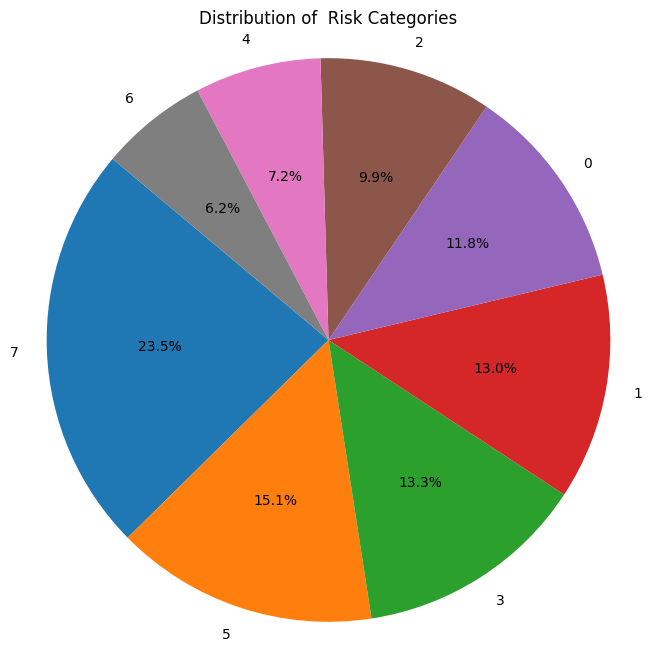

In [ ]:
category_counts = test_df['labels'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)


plt.title('Distribution of  Risk Categories')


plt.axis('equal')


plt.show()

In [ ]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(test_df)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/856 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['Article_Clean'])
tokenized_test_dataset.set_format('torch')

print("\nTokenized Test Dataset:")
print(tokenized_test_dataset)


Tokenized Test Dataset:
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 856
})


In [ ]:
test_results = final_trainer.predict(tokenized_test_dataset)

In [ ]:
final_metrics = test_results.metrics

print("\n--- Final Test Results ---")
print(final_metrics)


--- Final Test Results ---
{'test_loss': 0.6558200716972351, 'test_runtime': 14.297, 'test_samples_per_second': 59.873, 'test_steps_per_second': 7.484}


In [ ]:
from scipy.special import softmax
raw_predictions = test_results.predictions

probs = softmax(raw_predictions, axis=1)

confidences = probs.max(axis=1)

predicted_label_ids = probs.argmax(axis=1)




true_label_ids = test_results.label_ids

results_df = pd.DataFrame({
    "true"      : true_label_ids,
    "pred"      : predicted_label_ids,
    "confidence": confidences,
})

In [ ]:
results_df.head(20)

,true,pred,confidence
0,3,3,0.962742
1,7,7,0.994229
2,7,7,0.994737
3,7,7,0.994451
4,0,7,0.804509
5,7,7,0.994398
6,7,7,0.994446
7,4,4,0.997365
8,7,7,0.994593
9,0,0,0.997118



--- Final Test Results ---
{'test_loss': 0.6558200716972351, 'test_runtime': 14.297, 'test_samples_per_second': 59.873, 'test_steps_per_second': 7.484}


,threshold,precision,recall,f1,missed %,kept,coverage
0,0.00,0.854,0.841,0.843,0.000,856,1.000
1,0.05,0.854,0.841,0.843,0.000,856,1.000
2,0.10,0.854,0.841,0.843,0.000,856,1.000
3,0.15,0.854,0.841,0.843,0.000,856,1.000
4,0.20,0.854,0.841,0.843,0.000,856,1.000
5,0.25,0.854,0.841,0.843,0.000,856,1.000
6,0.30,0.854,0.841,0.843,0.000,856,1.000
7,0.35,0.856,0.841,0.845,0.234,854,0.998
8,0.40,0.856,0.841,0.845,0.234,854,0.998
9,0.45,0.858,0.841,0.846,0.350,853,0.996


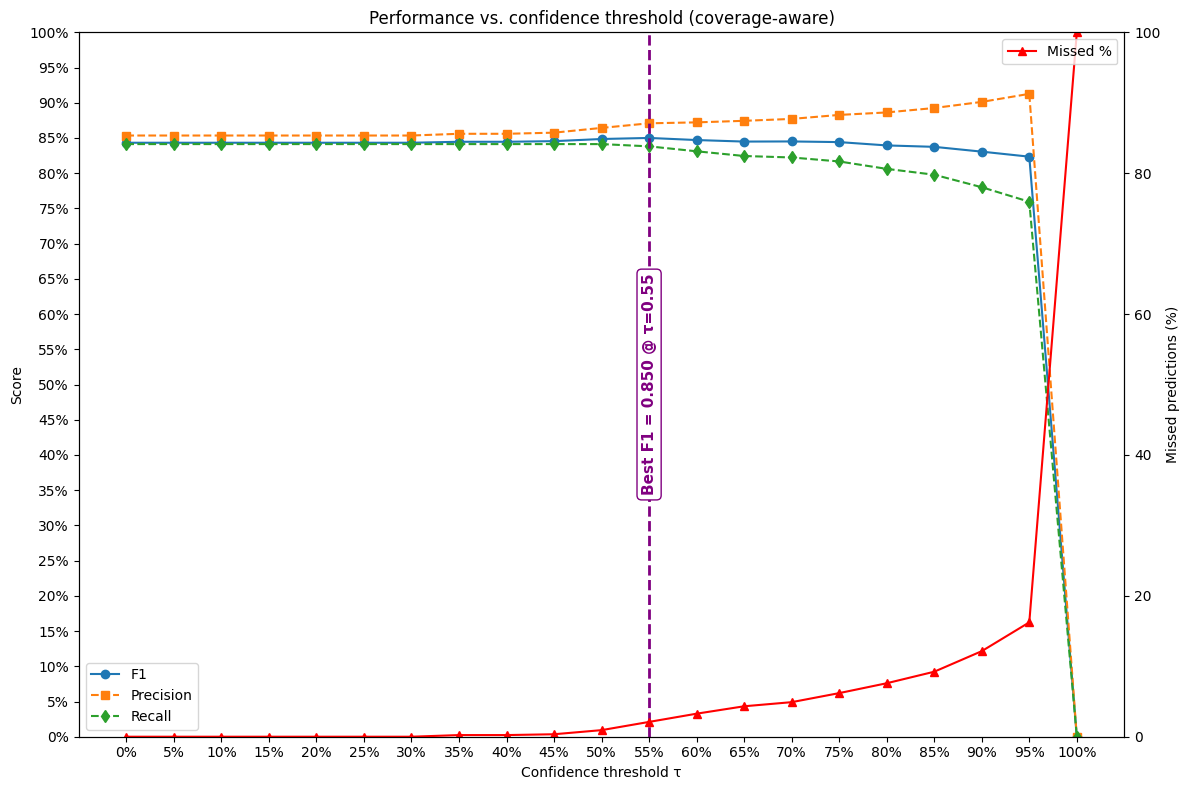

In [ ]:
from scipy.special import softmax
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


final_metrics = test_results.metrics
print("\n--- Final Test Results ---")
print(final_metrics)

raw_predictions = test_results.predictions
probs = softmax(raw_predictions, axis=1)
confidences = probs.max(axis=1)
predicted_label_ids = probs.argmax(axis=1)
true_label_ids = test_results.label_ids

results_df = pd.DataFrame({
    "true": true_label_ids,
    "pred": predicted_label_ids,
    "conf": confidences,
})

labels = np.unique(true_label_ids)
thresholds = np.arange(0.0, 1.01, 0.05)

records = []
N = len(results_df)

for τ in thresholds:
    kept_mask = results_df.conf >= τ
    kept = results_df[kept_mask]
    missed = results_df[~kept_mask]


    if len(kept):

        p_kept, r_kept, f_kept, support = precision_recall_fscore_support(
            kept.true, kept.pred, labels=labels, average=None, zero_division=0
        )

        from sklearn.metrics import confusion_matrix
        C = confusion_matrix(kept.true, kept.pred, labels=labels)
        TP = np.diag(C)
        FP = C.sum(axis=0) - TP
        FN = C.sum(axis=1) - TP


        missed_counts = pd.Series(missed.true).value_counts()
        for cls_idx, cnt in missed_counts.items():

            j = np.where(labels == cls_idx)[0][0]
            FN[j] += cnt


        with np.errstate(divide='ignore', invalid='ignore'):
            precision_per_class = np.where(TP + FP > 0, TP / (TP + FP), 0.0)
            recall_per_class    = np.where(TP + FN > 0, TP / (TP + FN), 0.0)
            f1_per_class = np.where(
                (precision_per_class + recall_per_class) > 0,
                2 * precision_per_class * recall_per_class / (precision_per_class + recall_per_class),
                0.0
            )


        p = precision_per_class.mean()
        r = recall_per_class.mean()
        f = f1_per_class.mean()
    else:

        p = 0.0
        r = 0.0
        f = 0.0

    missed_pct = (len(missed) / N) * 100.0
    records.append({
        "threshold": τ,
        "precision": p,
        "recall":    r,
        "f1":        f,
        "missed_pct": missed_pct,
        "kept":      len(kept),
        "coverage":  len(kept) / N
    })

perf = pd.DataFrame(records)
display(perf.round(3).rename(columns={"missed_pct": "missed %"}))

best_idx = perf['f1'].idxmax()
best_threshold = perf.loc[best_idx, 'threshold']
best_f1 = perf.loc[best_idx, 'f1']



fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(perf.threshold, perf.f1,        "o-", label="F1")
ax1.plot(perf.threshold, perf.precision, "s--", label="Precision")
ax1.plot(perf.threshold, perf.recall,    "d--", label="Recall")
ax1.set_xlabel("Confidence threshold τ")
ax1.set_ylabel("Score")
ax1.set_ylim(0, 1)
ax1.set_xticks(thresholds)
ax1.xaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_yticks(np.arange(0.0, 1.01, 0.05))
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.legend(loc="lower left")

ax1.axvline(best_threshold, color="purple", linestyle="--", linewidth=2)

ymin, ymax = ax1.get_ylim()
y_mid = (ymin + ymax) / 2

ax1.text(best_threshold, y_mid,
         f"Best F1 = {best_f1:.3f} @ τ={best_threshold:.2f}",
         color="purple", rotation=90, ha="center", va="center",
         fontsize=11, fontweight="bold",
         bbox=dict(facecolor="white", edgecolor="purple", boxstyle="round,pad=0.3"))

ax2 = ax1.twinx()
ax2.plot(perf.threshold, perf["missed_pct"], "^-", color="red", label="Missed %")
ax2.set_ylabel("Missed predictions (%)")
ax2.set_ylim(0, 100)
ax2.legend(loc="upper right")

plt.title("Performance vs. confidence threshold (coverage-aware)")
plt.tight_layout()
plt.show()

\n--- Final Classification Report on Test Data ---
                                       precision    recall  f1-score   support

                                Crime       0.83      0.63      0.72       101
                           Kidnapping       0.89      0.98      0.93       111
Terrorism and political violence acts       0.70      0.79      0.74        85
                         Civil unrest       0.93      0.82      0.87       114
                Road traffic accident       0.86      0.97      0.91        62
                              Medical       0.85      0.86      0.85       129
       Environmental & Infrastructure       0.93      0.77      0.85        53
                                Other       0.85      0.90      0.87       201

                             accuracy                           0.85       856
                            macro avg       0.85      0.84      0.84       856
                         weighted avg       0.85      0.85      0.85       856

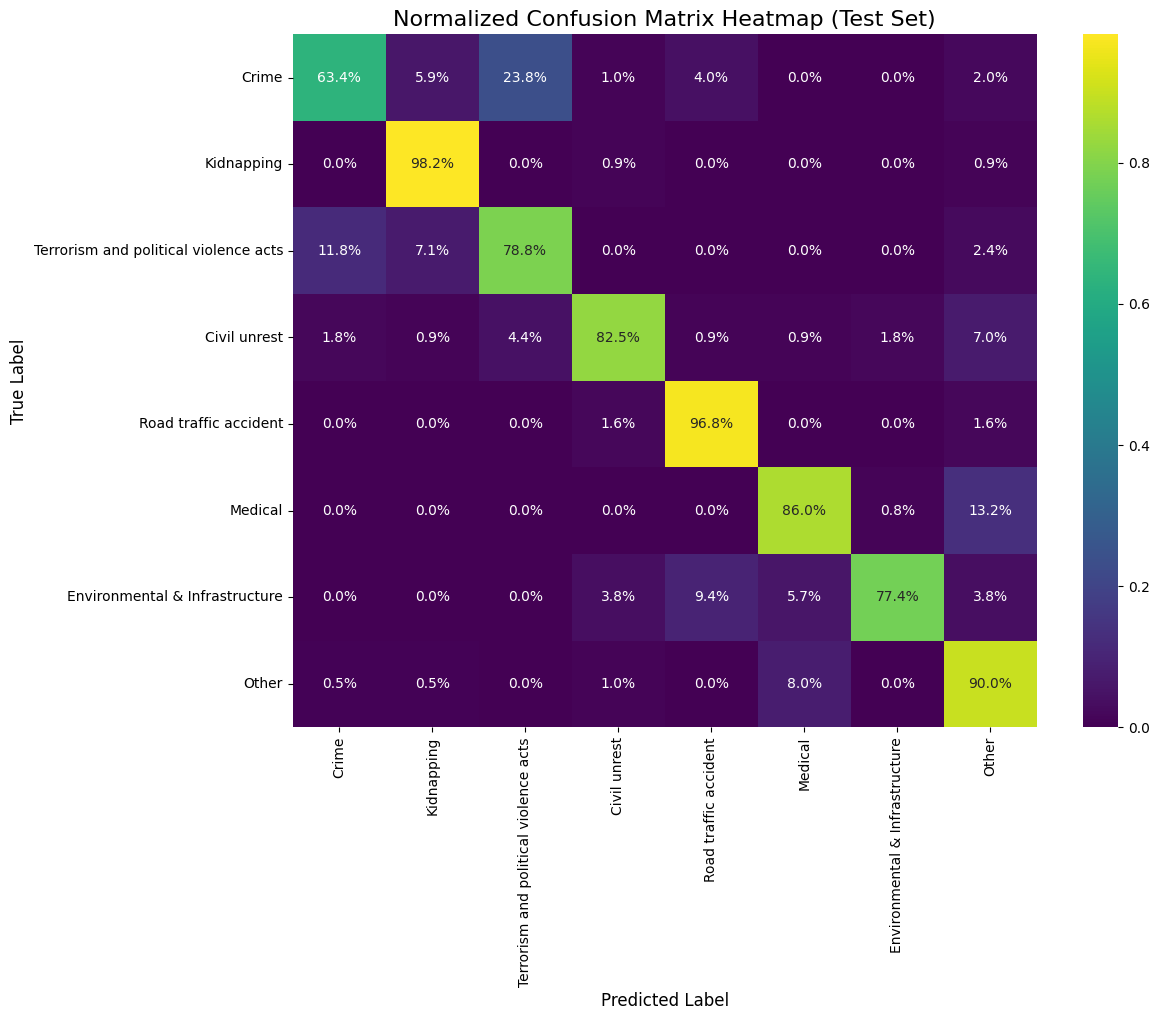

In [ ]:
from sklearn.metrics import classification_report
category_names = list(id2label.values())
report = classification_report(true_label_ids, predicted_label_ids, target_names=category_names)

print("\\n--- Final Classification Report on Test Data ---")
print(report)

report_dict = classification_report(true_label_ids, predicted_label_ids, output_dict=True)

accuracy = report_dict['accuracy']
macro_f1 = report_dict['macro avg']['f1-score']
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']

print("\\n--- Overall Performance Metrics ---")
print(f"Accuracy:          {accuracy:.4f}")
print(f"Macro F1-Score:    {macro_f1:.4f}")
print(f"Macro Precision:   {macro_precision:.4f}")
print(f"Macro Recall:      {macro_recall:.4f}")


cm = confusion_matrix(true_label_ids, predicted_label_ids)
cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)
cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)

plt.figure(figsize=(12, 9))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap="viridis"
)

plt.title('Normalized Confusion Matrix Heatmap (Test Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


In [ ]:
results_df = pd.DataFrame({
    'True_Label_ID': true_label_ids,
    'Predicted_Label_ID': predicted_label_ids
})

results_df['True_Label'] = results_df['True_Label_ID'].map(id2label)
results_df['Predicted_Label'] = results_df['Predicted_Label_ID'].map(id2label)



results_df['Article'] = test_df['Article_Clean'].reset_index(drop=True)



results_df['Correct'] = (results_df['True_Label'] == results_df['Predicted_Label'])

final_results_df = results_df[['Article', 'True_Label', 'Predicted_Label', 'Correct']]


print("--- Final Results with Article Text ---")
print(final_results_df.head(20
))

--- Final Results with Article Text ---
                                              Article             True_Label  \
0   Govt reopens Kwara college after five-week clo...           Civil unrest   
1   Replace Tinubu as candidate, Atiku's spokesper...                  Other   
2   Aregbesola backs community participation in ta...                  Other   
3   Atiku-Okowa campaign, PDP govs hail Adeleke on...                  Other   
4   Soldiers kill four bandits in Kaduna LGA Break...                  Crime   
5   How Obi can win presidential election - Primat...                  Other   
6   How Obi can win presidential election - Primat...                  Other   
7   How Obi can win presidential election - Primat...  Road traffic accident   
8   How Obi can win presidential election - Primat...                  Other   
9   How Obi can win presidential election - Primat...                  Crime   
10  How Obi can win presidential election - Primat...                  Other   


In [ ]:
final_results_df.to_excel("2_news_classification_results.xlsx", index=False)

/tmp/ipython-input-951799138.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


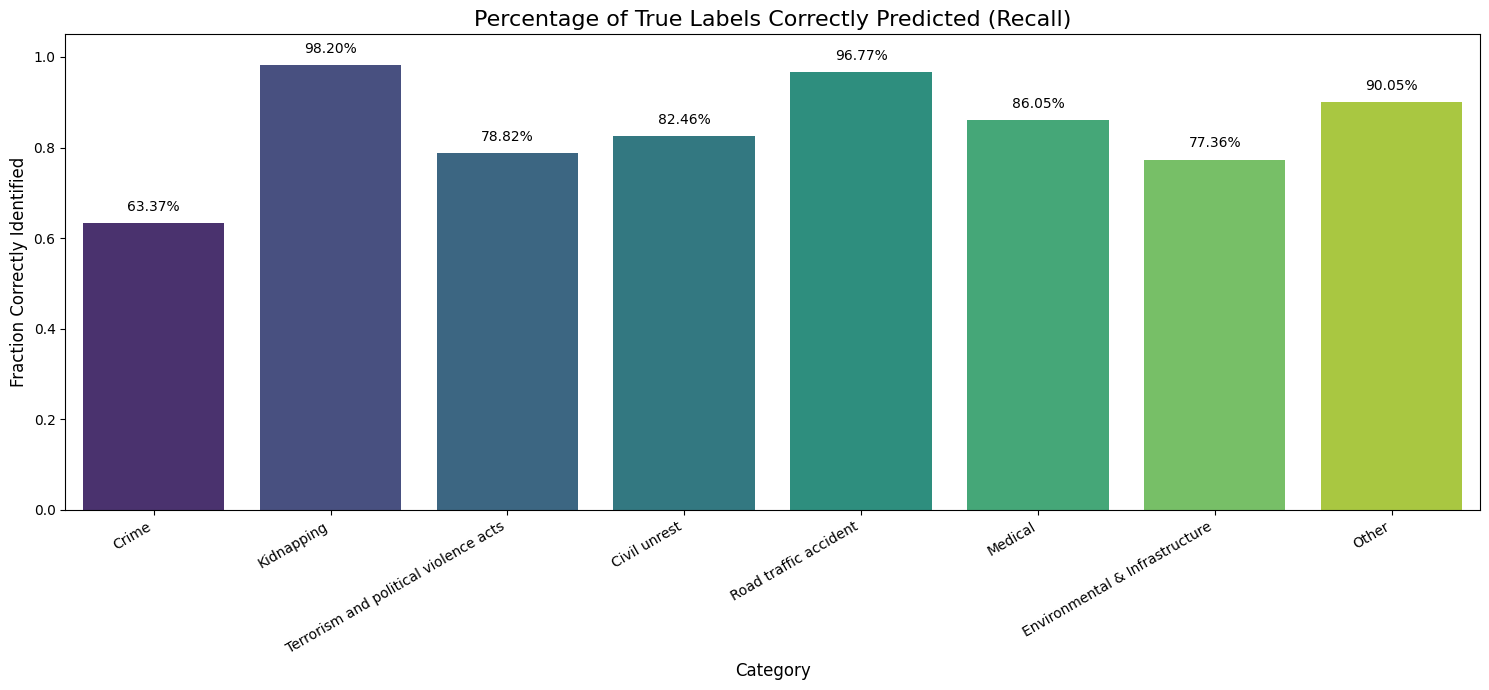

In [ ]:
labels = sorted(id2label.keys())
target_names = [id2label[i] for i in labels]

report = classification_report(
    true_label_ids, predicted_label_ids,
    labels=labels, target_names=target_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report).T

report_df = report_df.loc[target_names]

import seaborn as sns
plt.figure(figsize=(15,7))
sns.barplot(
    x=report_df.index,
    y=report_df['recall'],
    palette='viridis',
    errorbar=None
)
plt.title('Percentage of True Labels Correctly Predicted (Recall)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Fraction Correctly Identified', fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')


for i, v in enumerate(report_df['recall'].values):
    plt.text(i, min(v + 0.02, 1.02), f"{v:.2%}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix



category_names = list(id2label.values())

cm = confusion_matrix(true_label_ids, predicted_label_ids)

cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)

print("--- Confusion Matrix (Raw Counts) ---")
print("Rows = True Labels, Columns = Predicted Labels")
print(cm_df)

--- Confusion Matrix (Raw Counts) ---
Rows = True Labels, Columns = Predicted Labels
                                       Crime  Kidnapping  \
Crime                                     64           6   
Kidnapping                                 0         109   
Terrorism and political violence acts     10           6   
Civil unrest                               2           1   
Road traffic accident                      0           0   
Medical                                    0           0   
Environmental & Infrastructure             0           0   
Other                                      1           1   

                                       Terrorism and political violence acts  \
Crime                                                                     24   
Kidnapping                                                                 0   
Terrorism and political violence acts                                     67   
Civil unrest                                          

In [ ]:
cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)

print("\n--- Normalized Confusion Matrix ---")

print(cm_normalized.style.format('{:.2%}'))


--- Normalized Confusion Matrix (Percentages) ---
This shows the percentage of predictions for each true label.


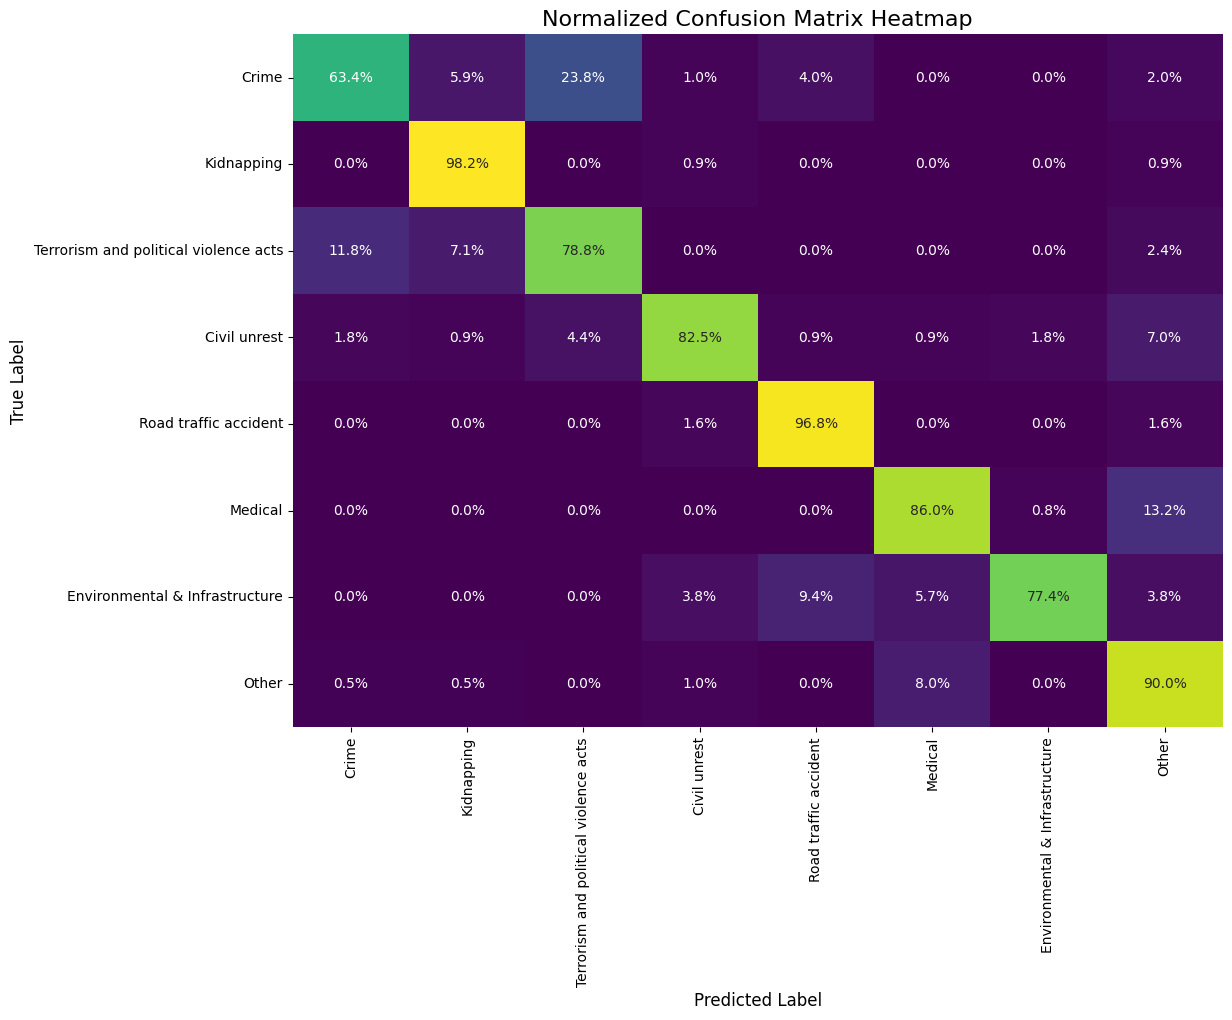

In [ ]:
plt.figure(figsize=(12, 9))


sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap="viridis",
    cbar=False
)

plt.title('Normalized Confusion Matrix Heatmap', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [ ]:
def count_sentences(text):

  if not isinstance(text, str) or not text:
    return 0

  sentences = re.split(r'(?<=[.!?])\s+', text)
  return len(sentences)



In [ ]:
sentence_counts = df_news_classification['Article_Clean'].apply(count_sentences)


average_sentences = sentence_counts.mean()
print(f"Average number of sentences per article in training dataset: {average_sentences:.2f}")

Average number of sentences per article in training dataset: 11.93


In [ ]:
sentence_counts = test_df['Article_Clean'].apply(count_sentences)


average_sentences = sentence_counts.mean()
print(f"Average number of sentences per article in test dataset: {average_sentences:.2f}")

Average number of sentences per article in test dataset: 8.68


In [ ]:
def count_words(text):

  if not isinstance(text, str) or not text:
    return 0
  words = text.split()
  return len(words)



In [ ]:
word_counts = df_news_classification['Article_Clean'].apply(count_words)

average_words = word_counts.mean()



print(f"The average number of words per article in training dataset: {average_words:.2f}")


The average number of words per article in training dataset: 281.29


In [ ]:
test_df["short_article"]= test_df['Article_Clean'].apply(get_first_n_sentences)
word_counts = test_df['short_article'].apply(count_words)

average_words = word_counts.mean()



print(f"The average number of words per article in test dataset: {average_words:.2f}")


The average number of words per article in test dataset: 250.19


# **OPTUNA**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
import torch

In [ ]:
model_name = "distilbert-base-uncased"
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    return model

In [ ]:
def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])


    lora_r = trial.suggest_categorical("lora_r", [8, 16, 32, 64,128,256,512,1024,2048,4096])
    lora_alpha = trial.suggest_categorical("lora_alpha", [16, 32, 64, 128,256,512,1024,2048,4096,8192])
    lora_dropout = trial.suggest_float("lora_dropout", 0.0, 0.1)

    model = model_init()
    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["q_lin", "v_lin"],
        lora_dropout=lora_dropout,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    lora_model = get_peft_model(model, lora_config)

    training_args = TrainingArguments(
        output_dir=f"./distilbert-lora-news-classifier-trial-{trial.number}",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        num_train_epochs=12,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        label_names=["labels"],
        push_to_hub=False,
    )







    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )


    trainer.train()


    eval_metrics = trainer.evaluate()


    return eval_metrics["eval_f1"]


study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)



best_params = study.best_params
print("\\n--- Best Hyperparameters Found ---")
print(best_params)


best_trial = study.best_trial
print(f"\\nBest F1 Score: {best_trial.value:.4f}")





[I 2025-07-21 22:12:10,952] A new study created in memory with name: no-name-d4e0a096-95ff-4cdb-9b40-3752eed9d693
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: smkh1u24 (smkh1u24-university-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.077400,2.064837,0.191419,0.133999,0.115865,0.191419
2,2.065800,2.051234,0.221122,0.136570,0.137362,0.221122
3,2.049200,2.038555,0.300330,0.220234,0.320179,0.300330
4,2.034400,2.026512,0.346535,0.270095,0.354544,0.346535
5,2.027300,2.013837,0.376238,0.291764,0.380784,0.376238
6,2.020600,2.001625,0.435644,0.361094,0.473945,0.435644
7,2.000700,1.989981,0.511551,0.440435,0.528528,0.511551
8,1.993500,1.979327,0.534653,0.466657,0.558071,0.534653
9,1.985200,1.970132,0.521452,0.458755,0.557757,0.521452
10,1.978200,1.963149,0.518152,0.459882,0.564949,0.518152


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-21 22:14:25,446] Trial 0 finished with value: 0.49524518746264257 and parameters: {'learning_rate': 1.3252233138209252e-05, 'weight_decay': 0.004790803026503032, 'per_device_train_batch_size': 32, 'lora_r': 1024, 'lora_alpha': 16, 'lora_dropout': 0.06975967257510506}. Best is trial 0 with value: 0.49524518746264257.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.072700,2.052994,0.174917,0.074675,0.073965,0.174917
2,2.036200,1.997986,0.462046,0.345953,0.384409,0.462046
3,1.963300,1.881731,0.620462,0.501876,0.683745,0.620462
4,1.816900,1.696658,0.745875,0.703719,0.833447,0.745875
5,1.631000,1.508599,0.831683,0.802939,0.871011,0.831683
6,1.467700,1.355546,0.871287,0.845731,0.894828,0.871287
7,1.327100,1.237566,0.874587,0.848633,0.891095,0.874587
8,1.226600,1.150130,0.887789,0.867142,0.901166,0.887789
9,1.143600,1.085889,0.897690,0.881277,0.908208,0.897690
10,1.085000,1.043153,0.891089,0.874603,0.901716,0.891089


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:15:45,348] Trial 1 finished with value: 0.88127671681576 and parameters: {'learning_rate': 1.2267906060271674e-05, 'weight_decay': 0.04532789604252942, 'per_device_train_batch_size': 16, 'lora_r': 32, 'lora_alpha': 128, 'lora_dropout': 0.010737519273810316}. Best is trial 1 with value: 0.88127671681576.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.072000,2.062223,0.141914,0.045803,0.159575,0.141914
2,2.050400,2.036680,0.207921,0.121654,0.361361,0.207921
3,2.030200,2.000893,0.382838,0.288077,0.403814,0.382838
4,1.980600,1.946408,0.584158,0.453081,0.543935,0.584158
5,1.926800,1.873746,0.620462,0.503583,0.663197,0.620462
6,1.860000,1.788114,0.689769,0.620797,0.796272,0.689769
7,1.763000,1.703222,0.759076,0.715928,0.831807,0.759076
8,1.691200,1.631308,0.792079,0.755271,0.849850,0.792079
9,1.635200,1.575543,0.811881,0.779588,0.859070,0.811881
10,1.592100,1.535750,0.825083,0.792342,0.865489,0.825083


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

[I 2025-07-21 22:17:00,940] Trial 2 finished with value: 0.8058624392164193 and parameters: {'learning_rate': 1.3777433447462715e-05, 'weight_decay': 0.017442111796355353, 'per_device_train_batch_size': 32, 'lora_r': 32, 'lora_alpha': 128, 'lora_dropout': 0.06123144116365059}. Best is trial 1 with value: 0.88127671681576.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.694800,1.106223,0.920792,0.906068,0.922462,0.920792
2,0.764500,0.467950,0.920792,0.912255,0.924233,0.920792
3,0.306300,0.258043,0.947195,0.940712,0.946611,0.947195
4,0.146200,0.240252,0.920792,0.914807,0.922363,0.920792
5,0.057700,0.199019,0.937294,0.934272,0.938413,0.937294
6,0.024500,0.225100,0.943894,0.938588,0.944721,0.943894


[I 2025-07-21 22:17:41,569] Trial 3 finished with value: 0.940712435549775 and parameters: {'learning_rate': 3.9302614347331366e-05, 'weight_decay': 0.07977836965805807, 'per_device_train_batch_size': 16, 'lora_r': 16, 'lora_alpha': 4096, 'lora_dropout': 0.08950239907622654}. Best is trial 3 with value: 0.940712435549775.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.556200,0.775999,0.877888,0.852404,0.884864,0.877888
2,0.560100,0.415534,0.904290,0.897813,0.911790,0.904290
3,0.249100,0.334367,0.914191,0.905547,0.915566,0.914191
4,0.137300,0.263344,0.933993,0.928558,0.935733,0.933993
5,0.091900,0.298654,0.940594,0.938228,0.942663,0.940594
6,0.070300,0.330017,0.950495,0.946292,0.951003,0.950495
7,0.044000,0.353778,0.943894,0.939063,0.944640,0.943894
8,0.044700,0.353702,0.950495,0.945805,0.951023,0.950495
9,0.014800,0.349386,0.957096,0.952403,0.957896,0.957096
10,0.019400,0.377212,0.953795,0.949181,0.953909,0.953795


[I 2025-07-21 22:19:06,882] Trial 4 finished with value: 0.9524025235991187 and parameters: {'learning_rate': 3.3857725821734954e-05, 'weight_decay': 0.039585203224919145, 'per_device_train_batch_size': 8, 'lora_r': 8, 'lora_alpha': 8192, 'lora_dropout': 0.09943814913751926}. Best is trial 4 with value: 0.9524025235991187.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.769300,1.289343,0.907591,0.895658,0.912133,0.907591
2,0.997400,0.671653,0.933993,0.922956,0.937311,0.933993
3,0.529100,0.379406,0.947195,0.942013,0.947727,0.947195
4,0.275800,0.252148,0.943894,0.937907,0.945010,0.943894
5,0.154400,0.200181,0.947195,0.942892,0.948276,0.947195
6,0.080900,0.173463,0.947195,0.942043,0.946860,0.947195
7,0.051800,0.230025,0.943894,0.937344,0.945691,0.943894
8,0.046200,0.209366,0.947195,0.942658,0.947750,0.947195


[I 2025-07-21 22:20:04,322] Trial 5 finished with value: 0.9428924491711128 and parameters: {'learning_rate': 2.2595746610904634e-05, 'weight_decay': 0.0581884461489273, 'per_device_train_batch_size': 8, 'lora_r': 8, 'lora_alpha': 2048, 'lora_dropout': 0.011953771409849656}. Best is trial 4 with value: 0.9524025235991187.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.065500,2.023099,0.346535,0.259316,0.399566,0.346535
2,1.942700,1.768084,0.709571,0.656721,0.819785,0.709571
3,1.620100,1.412295,0.831683,0.808412,0.865878,0.831683
4,1.301600,1.137171,0.861386,0.841305,0.879840,0.861386
5,1.076500,0.951329,0.877888,0.856309,0.889058,0.877888
6,0.903200,0.821663,0.887789,0.865959,0.896557,0.887789
7,0.787400,0.732918,0.897690,0.882340,0.900461,0.897690
8,0.712600,0.667534,0.910891,0.898633,0.913480,0.910891
9,0.648800,0.617832,0.914191,0.901636,0.917123,0.914191
10,0.601500,0.589340,0.914191,0.901445,0.916423,0.914191


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:21:31,407] Trial 6 finished with value: 0.9016355784439898 and parameters: {'learning_rate': 1.0731522291837105e-05, 'weight_decay': 0.031022869167076916, 'per_device_train_batch_size': 8, 'lora_r': 64, 'lora_alpha': 256, 'lora_dropout': 0.07069870086772846}. Best is trial 4 with value: 0.9524025235991187.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.032900,1.931377,0.561056,0.472358,0.511974,0.561056
2,1.764900,1.477947,0.828383,0.801656,0.874674,0.828383
3,1.298300,1.035578,0.887789,0.869731,0.899803,0.887789
4,0.893100,0.738628,0.904290,0.888521,0.908026,0.904290
5,0.663400,0.570796,0.917492,0.902710,0.921533,0.917492
6,0.505700,0.452333,0.927393,0.914460,0.928890,0.927393
7,0.406000,0.387033,0.924092,0.909789,0.925609,0.924092
8,0.347400,0.333514,0.947195,0.939708,0.947895,0.947195
9,0.294900,0.304134,0.943894,0.936648,0.944818,0.943894
10,0.270300,0.290051,0.943894,0.936648,0.944818,0.943894


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:22:40,727] Trial 7 finished with value: 0.9397075499973412 and parameters: {'learning_rate': 4.951187811108323e-05, 'weight_decay': 0.06260330893910021, 'per_device_train_batch_size': 32, 'lora_r': 16, 'lora_alpha': 256, 'lora_dropout': 0.046887714500150585}. Best is trial 4 with value: 0.9524025235991187.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.772600,1.075025,0.861386,0.839071,0.871378,0.861386
2,0.688800,0.398301,0.927393,0.922018,0.932022,0.927393
3,0.210900,0.195349,0.957096,0.954455,0.957593,0.957096
4,0.075900,0.201999,0.950495,0.947208,0.951635,0.950495
5,0.029800,0.227593,0.957096,0.954675,0.957375,0.957096
6,0.024800,0.277017,0.947195,0.942070,0.946860,0.947195
7,0.016000,0.274253,0.947195,0.944750,0.946941,0.947195
8,0.015300,0.266361,0.953795,0.951078,0.953464,0.953795


[I 2025-07-21 22:23:38,518] Trial 8 finished with value: 0.9546751688893786 and parameters: {'learning_rate': 2.5049768248831776e-05, 'weight_decay': 0.08199339344103915, 'per_device_train_batch_size': 8, 'lora_r': 32, 'lora_alpha': 8192, 'lora_dropout': 0.08759317446480008}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.900400,1.465886,0.808581,0.782118,0.861659,0.808581
2,1.086000,0.727658,0.904290,0.884191,0.909021,0.904290
3,0.516800,0.350979,0.943894,0.935132,0.945757,0.943894
4,0.248300,0.214552,0.953795,0.949075,0.954942,0.953795
5,0.140000,0.196154,0.940594,0.935371,0.941832,0.940594
6,0.081600,0.182751,0.940594,0.934651,0.941654,0.940594
7,0.062700,0.169219,0.950495,0.946661,0.951161,0.950495


[I 2025-07-21 22:25:53,194] Trial 9 finished with value: 0.9490745545591683 and parameters: {'learning_rate': 2.3650513214276658e-05, 'weight_decay': 0.09821301119749762, 'per_device_train_batch_size': 8, 'lora_r': 4096, 'lora_alpha': 1024, 'lora_dropout': 0.06662749810045442}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.732400,0.980035,0.907591,0.893618,0.910843,0.907591
2,0.588200,0.344512,0.940594,0.934564,0.943501,0.940594
3,0.155000,0.219321,0.940594,0.936547,0.940874,0.940594
4,0.053000,0.251512,0.947195,0.941419,0.948229,0.947195
5,0.026700,0.283287,0.943894,0.938515,0.944634,0.943894
6,0.015400,0.263594,0.947195,0.943599,0.947054,0.947195
7,0.003800,0.294461,0.950495,0.948313,0.951222,0.950495
8,0.001600,0.296285,0.950495,0.948341,0.950775,0.950495
9,0.001300,0.304244,0.950495,0.947825,0.950381,0.950495
10,0.001200,0.306854,0.950495,0.947825,0.950381,0.950495


[I 2025-07-21 22:27:15,025] Trial 10 finished with value: 0.9483409213445511 and parameters: {'learning_rate': 2.8889676696246632e-05, 'weight_decay': 0.09880787670468545, 'per_device_train_batch_size': 8, 'lora_r': 128, 'lora_alpha': 8192, 'lora_dropout': 0.03641287642753147}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.630200,0.793530,0.910891,0.901513,0.913157,0.910891
2,0.428600,0.295932,0.933993,0.928565,0.936399,0.933993
3,0.116900,0.211691,0.947195,0.943918,0.948068,0.947195
4,0.058700,0.231795,0.947195,0.943562,0.948642,0.947195
5,0.027100,0.277286,0.940594,0.935355,0.942460,0.940594
6,0.015800,0.257895,0.947195,0.943862,0.947109,0.947195


[I 2025-07-21 22:28:33,660] Trial 11 finished with value: 0.9439177295487742 and parameters: {'learning_rate': 3.39524926839722e-05, 'weight_decay': 0.038470896175024354, 'per_device_train_batch_size': 8, 'lora_r': 2048, 'lora_alpha': 8192, 'lora_dropout': 0.09919370448201217}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.696900,1.070430,0.900990,0.886531,0.905970,0.900990
2,0.779600,0.507253,0.933993,0.925323,0.933738,0.933993
3,0.358300,0.307363,0.943894,0.938824,0.943952,0.943894
4,0.177600,0.240982,0.943894,0.938604,0.945097,0.943894
5,0.087100,0.209164,0.957096,0.953689,0.958172,0.957096
6,0.055600,0.249857,0.950495,0.946424,0.950533,0.950495
7,0.032900,0.270088,0.943894,0.938233,0.943842,0.943894
8,0.018800,0.266725,0.957096,0.951886,0.957526,0.957096


[I 2025-07-21 22:29:31,114] Trial 12 finished with value: 0.9536886154357199 and parameters: {'learning_rate': 1.7604205517642383e-05, 'weight_decay': 0.07534492536053114, 'per_device_train_batch_size': 8, 'lora_r': 8, 'lora_alpha': 8192, 'lora_dropout': 0.09985291066539317}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.065100,2.027347,0.293729,0.198419,0.260326,0.293729
2,1.996200,1.911497,0.561056,0.447079,0.664177,0.561056
3,1.788100,1.561570,0.795380,0.761911,0.844049,0.795380
4,1.398800,1.158394,0.854785,0.835326,0.881885,0.854785
5,1.066500,0.888329,0.894389,0.881749,0.903812,0.894389
6,0.832800,0.720781,0.904290,0.894824,0.910533,0.904290
7,0.691000,0.613652,0.907591,0.899431,0.911092,0.907591
8,0.601000,0.543913,0.910891,0.902526,0.914933,0.910891
9,0.534500,0.495849,0.917492,0.908888,0.920368,0.917492
10,0.488700,0.466249,0.930693,0.923868,0.932551,0.930693


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:31:05,427] Trial 13 finished with value: 0.9238679625866757 and parameters: {'learning_rate': 1.632523127615529e-05, 'weight_decay': 0.07764515332020741, 'per_device_train_batch_size': 8, 'lora_r': 256, 'lora_alpha': 32, 'lora_dropout': 0.08394576626051083}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.004900,1.802625,0.660066,0.586382,0.782187,0.660066
2,1.552700,1.259516,0.891089,0.866515,0.905666,0.891089
3,1.126700,0.925737,0.907591,0.891555,0.910447,0.907591
4,0.829300,0.699833,0.910891,0.894540,0.914042,0.910891
5,0.633400,0.557450,0.924092,0.909501,0.925538,0.924092
6,0.496700,0.452726,0.917492,0.903086,0.919964,0.917492
7,0.416700,0.399764,0.920792,0.906457,0.923379,0.920792
8,0.353200,0.359022,0.924092,0.909910,0.926222,0.924092
9,0.304000,0.325871,0.930693,0.919546,0.933252,0.930693
10,0.275400,0.315460,0.930693,0.919649,0.932636,0.930693


[I 2025-07-21 22:32:31,061] Trial 14 finished with value: 0.9250591622240049 and parameters: {'learning_rate': 1.718326845418435e-05, 'weight_decay': 0.07541100567029392, 'per_device_train_batch_size': 8, 'lora_r': 8, 'lora_alpha': 512, 'lora_dropout': 0.0836375145792106}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.068900,2.042389,0.234323,0.103064,0.212216,0.234323
2,2.019300,1.964618,0.521452,0.393038,0.387693,0.521452
3,1.908700,1.781560,0.666667,0.567011,0.784801,0.666667
4,1.676600,1.498670,0.808581,0.776190,0.857951,0.808581
5,1.408500,1.245498,0.864686,0.838738,0.887869,0.864686
6,1.187900,1.056168,0.884488,0.864545,0.901337,0.884488
7,1.018100,0.919923,0.894389,0.880195,0.904071,0.894389
8,0.901800,0.825153,0.900990,0.890076,0.908909,0.900990
9,0.811100,0.758353,0.904290,0.893329,0.912021,0.904290
10,0.751000,0.715823,0.907591,0.896255,0.911240,0.907591


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:34:07,603] Trial 15 finished with value: 0.9011249547279363 and parameters: {'learning_rate': 1.8196282909003953e-05, 'weight_decay': 0.0860233074775674, 'per_device_train_batch_size': 16, 'lora_r': 512, 'lora_alpha': 64, 'lora_dropout': 0.028642788981866413}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.430500,0.727755,0.917492,0.905639,0.918979,0.917492
2,0.462300,0.315985,0.940594,0.933508,0.942340,0.940594
3,0.125900,0.230555,0.943894,0.939554,0.944940,0.943894
4,0.043100,0.329910,0.930693,0.923706,0.933262,0.930693
5,0.033300,0.351050,0.937294,0.932810,0.939655,0.937294
6,0.032700,0.341183,0.950495,0.945516,0.951402,0.950495
7,0.018600,0.341001,0.950495,0.946417,0.951134,0.950495
8,0.001000,0.386486,0.947195,0.944353,0.948159,0.947195
9,0.000700,0.385964,0.947195,0.944353,0.948159,0.947195
10,0.000600,0.387535,0.947195,0.944353,0.948159,0.947195


[I 2025-07-21 22:35:19,392] Trial 16 finished with value: 0.9464174746974031 and parameters: {'learning_rate': 2.566347596449342e-05, 'weight_decay': 0.06066721712930129, 'per_device_train_batch_size': 8, 'lora_r': 32, 'lora_alpha': 8192, 'lora_dropout': 0.08084216871650521}. Best is trial 8 with value: 0.9546751688893786.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.621800,0.915560,0.920792,0.914108,0.920913,0.920792
2,0.588600,0.393811,0.937294,0.926335,0.938960,0.937294
3,0.180800,0.179716,0.960396,0.957041,0.960457,0.960396
4,0.067100,0.183451,0.960396,0.956073,0.961120,0.960396
5,0.033700,0.169374,0.953795,0.950424,0.954817,0.953795
6,0.019000,0.241172,0.937294,0.930506,0.939219,0.937294


[I 2025-07-21 22:37:15,546] Trial 17 finished with value: 0.957041437755674 and parameters: {'learning_rate': 1.953094621185175e-05, 'weight_decay': 0.06767702535265344, 'per_device_train_batch_size': 8, 'lora_r': 4096, 'lora_alpha': 8192, 'lora_dropout': 0.09970340521115367}. Best is trial 17 with value: 0.957041437755674.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-2408977738.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.078400,2.057236,0.145215,0.037916,0.139018,0.145215
2,2.051400,2.034121,0.178218,0.090716,0.275837,0.178218
3,2.030500,2.013171,0.326733,0.218450,0.257957,0.326733
4,2.008700,1.992268,0.376238,0.257025,0.383994,0.376238
5,1.991600,1.969575,0.366337,0.229161,0.347508,0.366337
6,1.968400,1.946339,0.402640,0.285199,0.583472,0.402640
7,1.942400,1.922714,0.458746,0.361418,0.492536,0.458746
8,1.914900,1.900020,0.511551,0.428871,0.648019,0.511551
9,1.893200,1.879248,0.508251,0.425530,0.525894,0.508251
10,1.881500,1.862953,0.537954,0.457124,0.518710,0.537954


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packag

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[I 2025-07-21 22:40:48,228] Trial 18 finished with value: 0.4839009265725154 and parameters: {'learning_rate': 1.91325610768055e-05, 'weight_decay': 0.08820893018636539, 'per_device_train_batch_size': 32, 'lora_r': 4096, 'lora_alpha': 16, 'lora_dropout': 0.055102920508969845}. Best is trial 17 with value: 0.957041437755674.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.060100,2.014607,0.303630,0.183358,0.295113,0.303630
2,1.953400,1.807539,0.669967,0.570661,0.654317,0.669967
3,1.629200,1.347959,0.844884,0.819363,0.878756,0.844884
4,1.189300,0.966882,0.881188,0.870042,0.893019,0.881188
5,0.869600,0.718815,0.900990,0.889495,0.905541,0.900990
6,0.659400,0.569331,0.920792,0.910261,0.922713,0.920792
7,0.523300,0.473860,0.927393,0.919678,0.928959,0.927393
8,0.438500,0.410600,0.930693,0.925034,0.932718,0.930693
9,0.375100,0.366036,0.940594,0.934978,0.941539,0.940594
10,0.341800,0.343563,0.943894,0.937821,0.944616,0.943894


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[I 2025-07-21 22:44:27,510] Trial 19 finished with value: 0.9378205741067571 and parameters: {'learning_rate': 2.816202596835496e-05, 'weight_decay': 0.0683280440244685, 'per_device_train_batch_size': 16, 'lora_r': 4096, 'lora_alpha': 64, 'lora_dropout': 0.07768775469306598}. Best is trial 17 with value: 0.957041437755674.


\n--- Best Hyperparameters Found ---
{'learning_rate': 1.953094621185175e-05, 'weight_decay': 0.06767702535265344, 'per_device_train_batch_size': 8, 'lora_r': 4096, 'lora_alpha': 8192, 'lora_dropout': 0.09970340521115367}
\nBest F1 Score: 0.9570
